# Fastjet Issue?

In [1]:
from coffea.processor import ProcessorABC
from coffea import util
from coffea.nanoevents import BaseSchema
from coffea.dataset_tools import apply_to_fileset,max_chunks,preprocess
import dask
from dask.diagnostics import ProgressBar
import fastjet
import awkward as ak
import hist.dask as hda
import numpy as np
import os
import time
import sys
import vector
vector.register_awkward()

/home/prayag/coffeafcc/development/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
# Custom Recombiners
class E0_scheme(object):
    '''
    E0 Scheme Recombiner
    Find the C++ equivalent at https://github.com/HEP-FCC/FCCAnalyses/blob/master/addons/FastJet/src/ExternalRecombiner.cc
    '''
    def preprocess(pa):
        pa.reset(pa.px(), pa.py(), pa.pz(), pa.E())

    def recombine(pa, pb):
        psum = pa+pb
        
        pmag = (psum.px()**2 + psum.py()**2 + psum.pz()**2)**0.5
        E0scale = psum.E() / pmag
        psum.reset(
                psum.px()*E0scale,
                psum.py()*E0scale,
                psum.pz()*E0scale,
                psum.E()
        )
        return psum

In [3]:
def remove_muons(reco):
    '''Remove muons in a silly way:
    Remove any reco particle in the mass range 0.10566 +/- 0.03
    '''
    err = 0.03
    ll = reco.mass <= abs(0.10566-err)
    hl = reco.mass >= abs(0.10566+err)
    ll = ak.drop_none(ll)
    hl = ak.drop_none(hl)
    return reco[ll | hl]

In [4]:
#################################
#Begin the processor definition #
#################################
class simple_exclusive_cluster_ee_kt_algorithm(ProcessorABC):
    def __init__(self, *args, **kwargs):
        pass

    def process(self,events):

        Reco = ak.zip(
            {
                'E':events['ReconstructedParticles/ReconstructedParticles.energy'],
                'px':events['ReconstructedParticles/ReconstructedParticles.momentum.x'],
                'py':events['ReconstructedParticles/ReconstructedParticles.momentum.y'],
                'pz':events['ReconstructedParticles/ReconstructedParticles.momentum.z'],
            },
            with_name='Momentum4D'
        )
                      
        
        pseudo_jets = remove_muons(Reco)

        #Ensure there are at least 2 reco particles before clustering
        pseudo_jets = pseudo_jets[ak.num(pseudo_jets, axis=1) > 1]
        
        jetdef = fastjet.JetDefinition0Param(fastjet.ee_kt_algorithm)
        
        jetdef.set_python_recombiner(E0_scheme)
        
        cluster = fastjet.ClusterSequence(pseudo_jets, jetdef)
        
        jets = cluster.exclusive_jets(2)
        
        jet_constituents = cluster.exclusive_jets_constituents(2)
        
        dijets = ak.sum(jets, axis=1)

        h = hda.Hist.new.Reg(100,0,200).Double().fill(dijets.mass)

        return {'dijet_mass': h, 'metadata': events.metadata}

    def postprocess(self, accumulator):
        pass

## Run the processor

In [5]:
######################
# Define the fileset #
######################
# redirector = 'root://eospublic.cern.ch//'
redirector = ''
''' In case of problems, Download the root files from the following links:
https://prayag.web.cern.ch/share/FCC/eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root
'''
fileset = {
    'mumuHbb':{
        'files':{
            redirector+'eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root':'events'
        },
        'metadata':{
            'dataset':'wzp6_ee_mumuH_Hbb_ecm240',
            'source':'https://fcc-physics-events.web.cern.ch/fcc-ee/delphes/winter2023/idea/',
            'cross_section':0.00394, # in pb
            'comments':'H to bb',
            'label':'mumuHbb',
            'color':'red'
        }
    }
}

In [12]:
# Preprocess the fileset
dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=5_000,
    # files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

In [13]:
dataset_updated

{'mumuHbb': {'files': {'eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/wzp6_ee_mumuH_Hbb_ecm240/events_159112833.root': {'object_path': 'events',
    'steps': [[0, 5000],
     [5000, 10000],
     [10000, 15000],
     [15000, 20000],
     [20000, 25000],
     [25000, 30000],
     [30000, 35000],
     [35000, 40000],
     [40000, 45000],
     [45000, 50000],
     [50000, 55000],
     [55000, 60000],
     [60000, 65000],
     [65000, 70000],
     [70000, 75000],
     [75000, 80000],
     [80000, 85000],
     [85000, 90000],
     [90000, 95000],
     [95000, 100000]],
    'num_entries': 100000,
    'uuid': 'f24b1152-8e72-11ed-8419-8f398e80beef'}},
  'metadata': {'dataset': 'wzp6_ee_mumuH_Hbb_ecm240',
   'source': 'https://fcc-physics-events.web.cern.ch/fcc-ee/delphes/winter2023/idea/',
   'cross_section': 0.00394,
   'comments': 'H to bb',
   'label': 'mumuHbb',
   'color': 'red'},
  'form': None}}

In [15]:
# Build the dask taskgraph
to_compute = apply_to_fileset(
        simple_exclusive_cluster_ee_kt_algorithm(),
        dataset_runnable,
        schemaclass=BaseSchema,
        uproot_options={"filter_name": lambda x : "PARAMETERS" not in x}
    )

In [16]:
# Process
pgb = ProgressBar()
with pgb:
    (out,) = dask.compute(to_compute)

[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Completed | 42.47 s


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8728748530>, errorbar=None, legend_artist=None)]

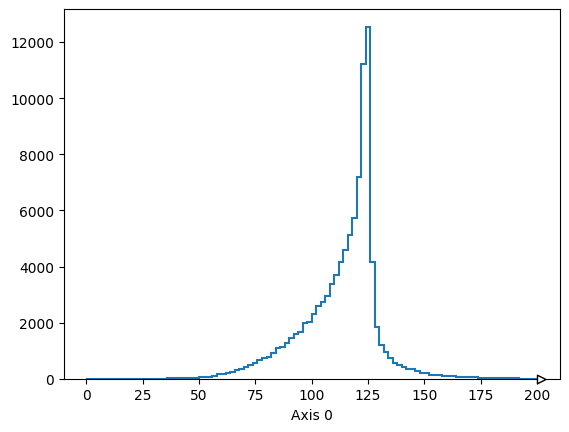

In [17]:
out['mumuHbb']['dijet_mass'].plot()

### This simplest example uses a lot of RAM

For a more realistic analyses, workers die because of hitting the RAM ceiling.
Wondering if this could be avoided

Total number of events in the current example : 100K
File size: 891 MB

RAM used: 7-8 GB

In the graph below refer to the green line in Memory:
The leftmost flat section : Idle
Upwards slope: The code executes
The rightmost flat section: Execution is completed but the Memory is not released

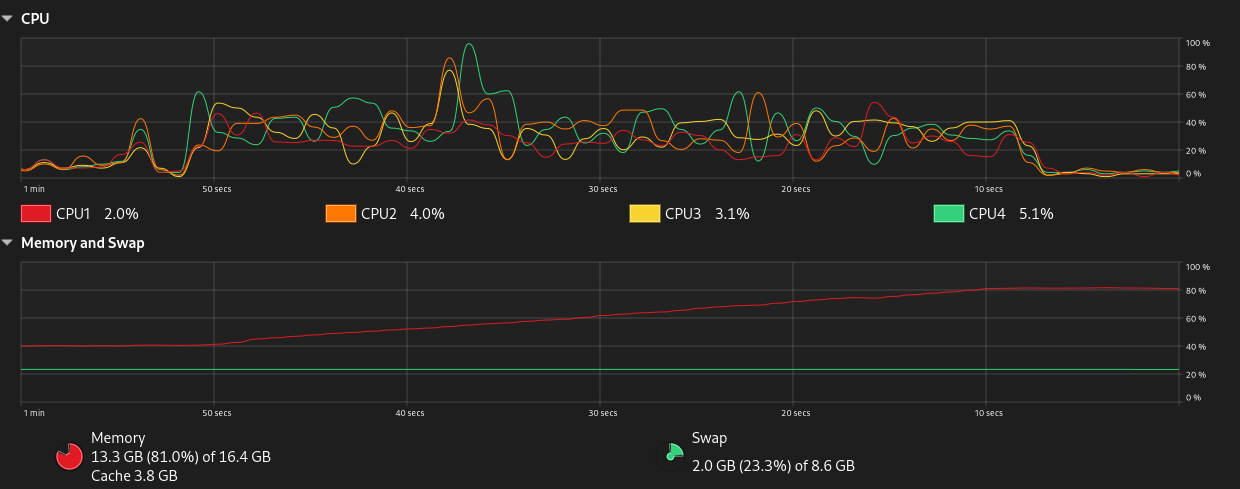

# Moreover, the used up memory is not released unless I restart my jupyter Kernel